https://github.com/KerasKorea/KEKOxTutorial/blob/master/20_Keras%EC%9D%98%20Autoencoder%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%B4%20%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C%20%EC%9D%B4%EC%83%81%20%EA%B1%B0%EB%9E%98%20%ED%83%90%EC%A7%80%ED%95%98%EA%B8%B0.md

In [1]:
import pandas as pd
import numpy as np
import math
import pickle
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import linalg, stats

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE

# 필요한 라이브러리 로드
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers

# 시각화 라이브러리 설정
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
df = pd.read_csv('../creditcard.csv')

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df = df.sample(frac=1)  #shuffle


# undersampling
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
df_un = normal_distributed_df.sample(frac=1, random_state=42)

# oversampling with SMOTE
sm = SMOTE(sampling_strategy='minority')
X_sm, y_sm = sm.fit_resample(df.drop('Class', axis=1), df['Class'])

In [3]:
X_sm.shape, y_sm.shape

((568630, 30), (568630,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], test_size=0.3, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((199364, 30), (199364,), (85443, 30), (85443,))

In [5]:
X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(df_un.drop('Class', axis=1), df_un['Class'], test_size=0.3, random_state=42)
X_train_un.shape, y_train_un.shape, X_test_un.shape, y_test_un.shape

((688, 30), (688,), (296, 30), (296,))

In [6]:
X_train_ov, X_test_ov, y_train_ov, y_test_ov = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)
X_train_ov.shape, y_train_ov.shape, X_test_ov.shape, y_test_ov.shape

((398041, 30), (398041,), (170589, 30), (170589,))

In [7]:
input_dim = X_train.shape[1]
#input_dim = X_train_ov.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [8]:
nb_epoch = 50
batch_size = 128
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/50
   1/1558 [..............................] - ETA: 0s - loss: 1.1511 - accuracy: 0.0469WARNING:tensorflow:From /home/jovyan/.venv/horovod0.20.3-tf2.3.0-torch1.6.0-mxnet1.6.0-py3.7-cuda10.1/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1558/1558 [==============================] - 7s 4ms/step - loss: 1.1109 - accuracy: 0.5334 - val_loss: 1.0798 - val_accuracy: 0.6337
Epoch 2/50
1558/1558 [==============================] - 6s 4ms/step - loss: 0.9436 - accuracy: 0.6441 - val_loss: 1.0013 - val_accuracy: 0.6551
Epoch 3/50
1558/1558 [==============================] - 7s 4ms/step - loss: 0.8902 - accuracy: 0.6680 - val_loss: 0.9579 - val_accuracy: 0.6784
Epoch 4/50
1558/1558 [==============================] - 6s 4ms/step - loss: 0.8597 - accuracy: 0.6807 - val_loss: 0.9302 - val_accuracy: 

In [9]:
autoencoder = load_model('model.h5')

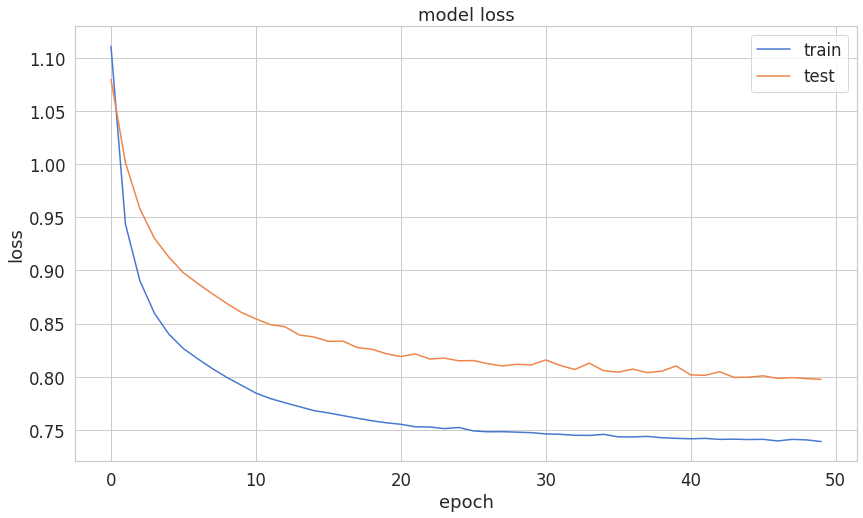

In [10]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [11]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1) #X_test
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})  #y_test
error_df.describe()

,reconstruction_error,true_class
count,85443.000000,85443.000000
mean,0.796615,0.001662
std,15.090594,0.040733
min,0.050647,0.000000
25%,0.241384,0.000000
50%,0.384847,0.000000
75%,0.606779,0.000000
max,4006.040558,1.000000


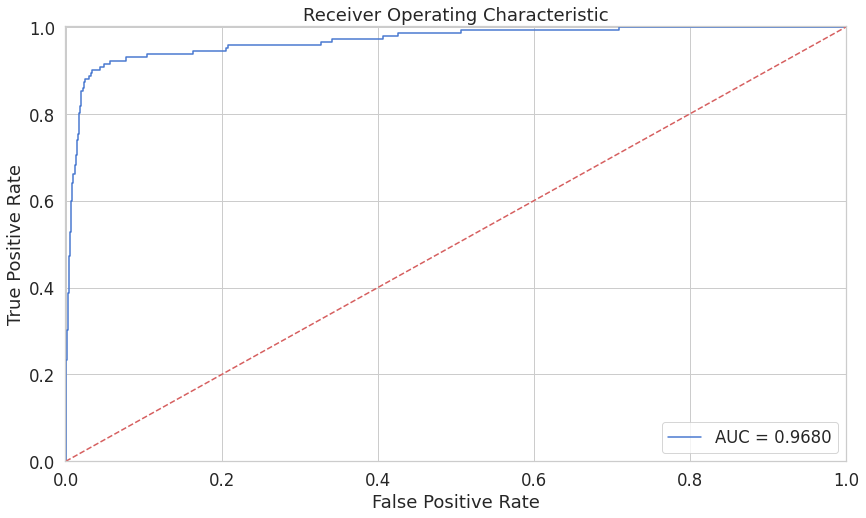

In [12]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)


fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [13]:
threshold = 2.9

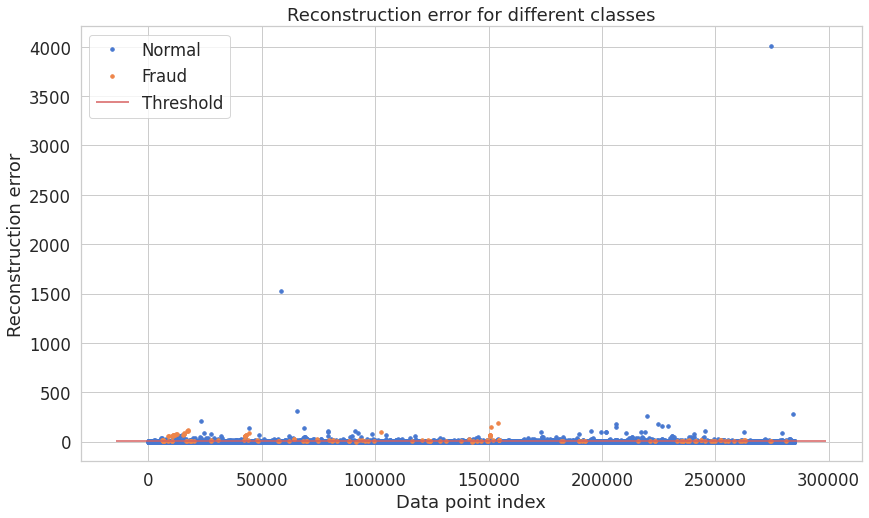

In [14]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

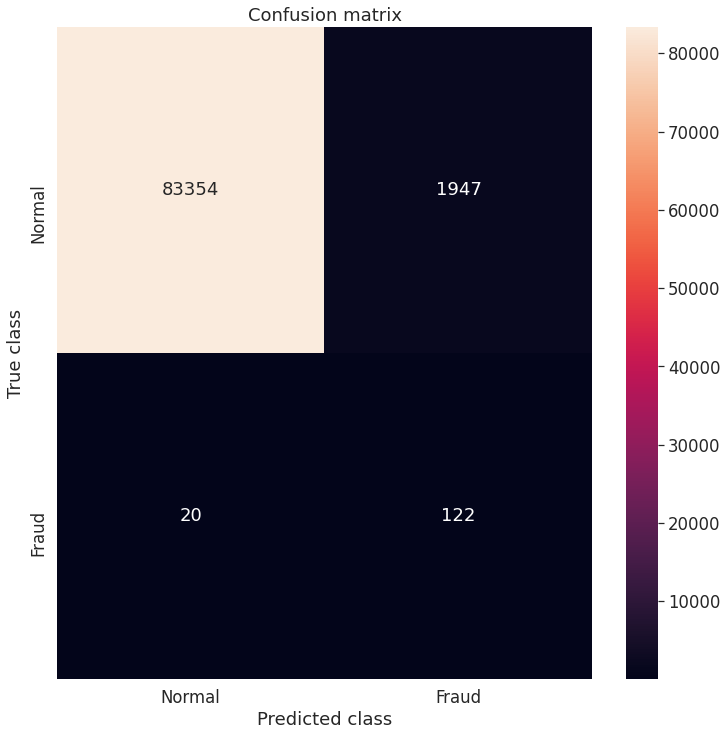

In [15]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [16]:
round(accuracy_score(y_test, y_pred), 6)

0.976979

In [17]:
f1_score(y_test, y_pred, average='weighted')

0.9868793804294905

In [18]:
f1_score(y_pred, y_test, average='weighted')

0.9670782287368541

In [19]:
round(roc_auc_score(y_test, y_pred), 6)

0.918165